# 0.Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer



# 1.Clustering por tienda

In [2]:
df= pd.read_csv("/Users/santi/Documents/csv/datos_arreglados.csv",index_col=0)

In [3]:
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

In [4]:
df.head()

,item,category,department,stores,region,week,year,is_holidays,units_sold,sell_price,total_sales
date,,,,,,,,,,,
2013-07-08,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,0,0,12.7414,0.0000
2013-07-15,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,1,0,12.7414,0.0000
2013-07-22,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,29,2013,0,4,10.9858,43.9432
2013-07-29,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,30,2013,0,6,10.9858,65.9148
2013-08-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,31,2013,0,0,10.9858,0.0000


In [5]:
df_tiendas = df.groupby(["stores"]).agg({"region":"first",
                                        "units_sold":"sum",
                                        "sell_price":"mean",
                                        "total_sales":"sum"}).reset_index()

df_tiendas

,stores,region,units_sold,sell_price,total_sales
0,Back_Bay(BOS_3),Boston,6057234,5.484508,2.181127e+07
1,Brooklyn(NYC_4),New York,4082201,5.522663,1.495885e+07
2,Greenwich_Village(NYC_1),New York,7657224,5.516056,2.757273e+07
3,Harlem(NYC_2),New York,5647131,5.576188,2.135534e+07
4,Midtown_Village(PHI_1),Philadelphia,5115653,5.580032,1.811085e+07
5,Queen_Village(PHI_3),Philadelphia,6391946,5.520492,2.063028e+07
6,Roxbury(BOS_2),Boston,7178136,5.455508,2.512650e+07
7,South_End(BOS_1),Boston,5567261,5.465372,1.923361e+07
8,Tribeca(NYC_3),New York,11134789,5.483638,3.928694e+07
9,Yorktown(PHI_2),Philadelphia,6506176,5.555507,2.152227e+07


In [6]:
df_perc = pd.crosstab(df["stores"],df["category"],values=df["total_sales"], aggfunc="sum",normalize="index").reset_index()
df_perc 

category,stores,ACCESORIES,HOME_&_GARDEN,SUPERMARKET
0,Back_Bay(BOS_3),0.154744,0.290987,0.554269
1,Brooklyn(NYC_4),0.165118,0.256545,0.578337
2,Greenwich_Village(NYC_1),0.151246,0.269476,0.579278
3,Harlem(NYC_2),0.133760,0.389210,0.477030
4,Midtown_Village(PHI_1),0.170094,0.284054,0.545852
5,Queen_Village(PHI_3),0.104145,0.274484,0.621371
6,Roxbury(BOS_2),0.139968,0.293489,0.566543
7,South_End(BOS_1),0.113305,0.325477,0.561218
8,Tribeca(NYC_3),0.113925,0.332989,0.553085
9,Yorktown(PHI_2),0.086750,0.281245,0.632005


In [7]:
df_cluster_tiendas= df_tiendas.merge(df_perc,on="stores")
df_cluster_tiendas.head()

,stores,region,units_sold,sell_price,total_sales,ACCESORIES,HOME_&_GARDEN,SUPERMARKET
0,Back_Bay(BOS_3),Boston,6057234,5.484508,2.181127e+07,0.154744,0.290987,0.554269
1,Brooklyn(NYC_4),New York,4082201,5.522663,1.495885e+07,0.165118,0.256545,0.578337
2,Greenwich_Village(NYC_1),New York,7657224,5.516056,2.757273e+07,0.151246,0.269476,0.579278
3,Harlem(NYC_2),New York,5647131,5.576188,2.135534e+07,0.133760,0.389210,0.477030
4,Midtown_Village(PHI_1),Philadelphia,5115653,5.580032,1.811085e+07,0.170094,0.284054,0.545852


/var/folders/h2/m__59kjn7y17pxmn41zlkfsm0000gn/T/ipykernel_28748/3964144302.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_cluster_tiendas.corr(), annot=True, cmap="YlGnBu")


<Axes: >

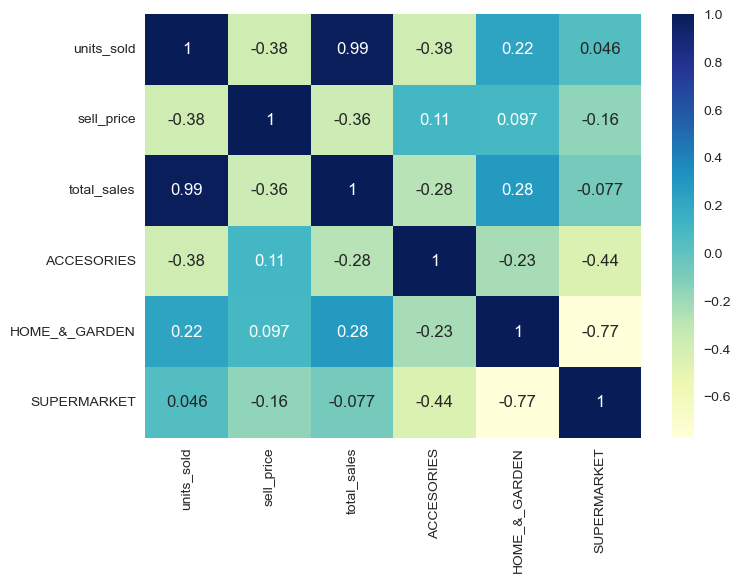

In [8]:
sns.heatmap(df_cluster_tiendas.corr(), annot=True, cmap="YlGnBu")

In [9]:
df_cluster= df_cluster_tiendas.copy()

In [10]:
df_cluster.drop(columns=["total_sales","HOME_&_GARDEN","region"],inplace=True)
tiendas = df_cluster.pop("stores")
tiendas

0             Back_Bay(BOS_3)
1             Brooklyn(NYC_4)
2    Greenwich_Village(NYC_1)
3               Harlem(NYC_2)
4      Midtown_Village(PHI_1)
5        Queen_Village(PHI_3)
6              Roxbury(BOS_2)
7            South_End(BOS_1)
8              Tribeca(NYC_3)
9             Yorktown(PHI_2)
Name: stores, dtype: object

In [11]:
ss = StandardScaler()
df_cluster_ss = pd.DataFrame(
    ss.fit_transform(df_cluster),
    columns=df_cluster.columns)
df_cluster_ss

,units_sold,sell_price,ACCESORIES,SUPERMARKET
0,-0.262981,-0.750375,0.811173,-0.311947
1,-1.352909,0.158874,1.203697,0.282505
2,0.619979,0.001414,0.678823,0.305753
3,-0.489297,1.434361,0.017194,-2.219681
4,-0.782595,1.525974,1.391987,-0.519833
5,-0.078269,0.107134,-1.103348,1.345410
6,0.355593,-1.441436,0.252084,-0.008785
7,-0.533374,-1.206382,-0.756771,-0.140309
8,2.539084,-0.771115,-0.733294,-0.341183
9,-0.015231,0.941550,-1.761545,1.608069


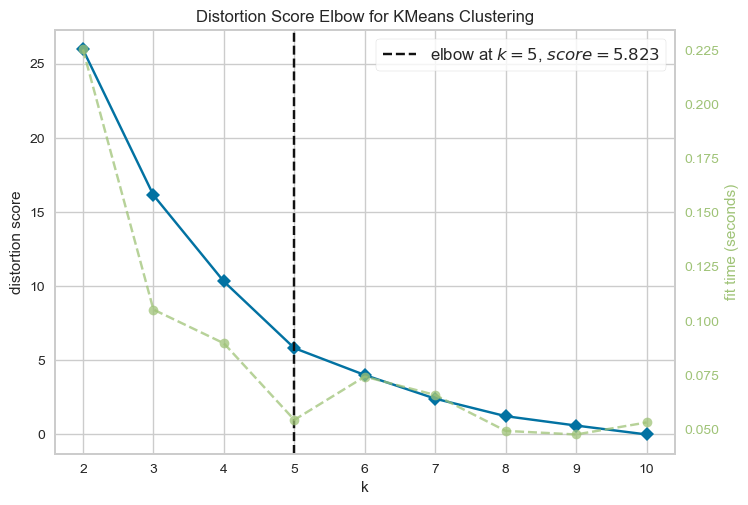

In [12]:
Elbow_M = KElbowVisualizer(KMeans(random_state=42, init="random", n_init="auto"), k=10)
Elbow_M.fit(df_cluster_ss)
Elbow_M.show();

In [13]:
import plotly.express as px

silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
    kmeans.fit(df_cluster_ss)
    silhouette_scores.append(silhouette_score(df_cluster_ss, kmeans.labels_))

fig = px.line(
    x=range(2, 10),
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

# 2. Clustering por producto